<a href="https://colab.research.google.com/github/AliAbdallah21/ReAct-AI-Agents/blob/main/Build_ReAct_AI_Agents_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt update
!apt install -y graphviz libgraphviz-dev pkg-config

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,297 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,272 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InReleas

In [2]:
%%capture
!pip install langgraph==0.3.34 langchain-openai==0.3.14 langchainhub==0.1.21 langchain==0.3.24 pygraphviz==1.14 langchain-community==0.3.23

In [5]:
import warnings
warnings.filterwarnings('ignore')

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
import os
import json

from google.colab import userdata



In [6]:
tavily_api_key =  userdata.get('TAVILY_API_KEY')

In [12]:
if tavily_api_key is not None:
  search = TavilySearchResults(tavily_api_key = tavily_api_key)
else:
  print("Tavily API key not found. Please ensure it is set in Colab secrets.")

In [13]:
@tool
def search_tool(query: str):
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    return search.invoke(query)

In [14]:
search_tool("What's the weather like in Tokyo today?")

[{'title': 'Tokyo weather in August 2025',
  'url': 'https://www.weather25.com/asia/japan/tokyo?page=month&month=August',
  'content': 'Patchy rain possible\nSunny\nPartly cloudy\nSunny\nPartly cloudy\nPartly cloudy\nLight rain shower\nPartly cloudy\nSunny\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible\nLight rain shower\nPartly cloudy\nModerate or heavy rain shower\nPatchy rain possible\nPatchy rain possible\nPartly cloudy\nPartly cloudy\nPatchy rain possible\nPartly cloudy\nLight rain shower\nPatchy light drizzle\nPartly cloudy\nPatchy rain possible\nLight rain shower\nPartly cloudy\nPartly cloudy\nPartly cloudy\nSunny [...] weather25.com\nSearch\nweather in Japan\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in Japan\n\n# Tokyo weather in August 2025\n\nClear\nClear\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible\nPartly cloudy\nClear\nSunny\nPatchy rain possible\nPartly cloudy\nPatchy rain possib

In [15]:
@tool
def recommend_clothing(weather: str) -> str:
    """
    Returns a clothing recommendation based on the provided weather description.

    This function examines the input string for specific keywords or temperature indicators
    (e.g., "snow", "freezing", "rain", "85°F") to suggest appropriate attire. It handles
    common weather conditions like snow, rain, heat, and cold by providing simple and practical
    clothing advice.

    :param weather: A brief description of the weather (e.g., "Overcast, 64.9°F")
    :return: A string with clothing recommendations suitable for the weather
    """
    weather = weather.lower()
    if "snow" in weather or "freezing" in weather:
        return "Wear a heavy coat, gloves, and boots."
    elif "rain" in weather or "wet" in weather:
        return "Bring a raincoat and waterproof shoes."
    elif "hot" in weather or "85" in weather:
        return "T-shirt, shorts, and sunscreen recommended."
    elif "cold" in weather or "50" in weather:
        return "Wear a warm jacket or sweater."
    else:
        return "A light jacket should be fine."

In [17]:
recommend_clothing("What to wear during the hot morning day tomorrow in Cairo Egypt")

'T-shirt, shorts, and sunscreen recommended.'

In [18]:
tools=[search_tool,recommend_clothing]

tools_by_name={ tool.name:tool for tool in tools}

In [19]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

model = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'))

In [20]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage,SystemMessage

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful AI assistant that thinks step-by-step and uses tools when needed.

When responding to queries:
1. First, think about what information you need
2. Use available tools if you need current data or specific capabilities
3. Provide clear, helpful responses based on your reasoning and any tool results

Always explain your thinking process to help users understand your approach.
"""),
    MessagesPlaceholder(variable_name="scratch_pad")
])

In [21]:
model_react=chat_prompt|model.bind_tools(tools)

In [23]:
from typing import (Annotated,Sequence,TypedDict)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [24]:
# Example conversation flow:
state: AgentState = {"messages": []}

# append a message using the reducer properly
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Hi")])
print("After greeting:", state["messages"])

# add another message (e.g. a question)
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Weather in NYC?")])
print("After question:", state)

After greeting: [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='b46a1af2-995f-48fb-8eb7-90ca357437c9')]
After question: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='b46a1af2-995f-48fb-8eb7-90ca357437c9'), HumanMessage(content='Weather in NYC?', additional_kwargs={}, response_metadata={}, id='45b98a84-7972-42c8-a8fb-d8bdeb6fc0e7')]}


In [25]:
dummy_state: AgentState = {
    "messages": [HumanMessage( "What's the weather like in Zurich, and what should I wear based on the temperature?")]}

response = model_react.invoke({"scratch_pad":dummy_state["messages"]})

dummy_state["messages"]=add_messages(dummy_state["messages"],[response])

In [29]:
tool_call = response.tool_calls[-1]
print("Tool call:", tool_call)
tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
print("Tool result preview:", tool_result[0]['title'])


tool_message = ToolMessage(
    content=json.dumps(tool_result),
    name=tool_call["name"],
    tool_call_id=tool_call["id"]
)
dummy_state["messages"] = add_messages(dummy_state["messages"], [tool_message])

Tool call: {'name': 'search_tool', 'args': {'query': 'current weather in Zurich'}, 'id': 'call_vZs2vJf79OXP9aM2dm4WewQz', 'type': 'tool_call'}
Tool result preview: Zurich weather in August 2025 - Weather25.com


In [31]:
response = model_react.invoke({"scratch_pad": dummy_state["messages"]})
dummy_state['messages'] = add_messages(dummy_state['messages'], [response])

# check if the model wants to use another tool
if response.tool_calls:
    tool_call = response.tool_calls[0]
    tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
    tool_message = ToolMessage(
        content=json.dumps(tool_result),
        name=tool_call["name"],
        tool_call_id=tool_call["id"]
    )
    dummy_state['messages'] = add_messages(dummy_state['messages'], [tool_message])

In [32]:
response = model_react.invoke({"scratch_pad": dummy_state["messages"]})
print("Final response generated:", response.content is not None)
print("More tools needed:", bool(response.tool_calls))

Final response generated: True
More tools needed: False


In [33]:
def tool_node(state: AgentState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

In [34]:
def call_model(state: AgentState):
    """Invoke the model with the current conversation state."""
    response = model_react.invoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

In [35]:
def should_continue(state: AgentState):
    """Determine whether to continue with tool use or end the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [36]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Add edges between nodes
workflow.add_edge("tools", "agent")  # After tools, always go back to agent

# Add conditional logic
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",  # If tools needed, go to tools node
        "end": END,          # If done, end the conversation
    },
)

# Set entry point
workflow.set_entry_point("agent")

# Compile the graph
graph = workflow.compile()

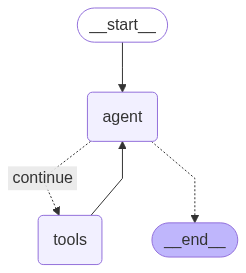

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
def print_stream(stream):
    """Helper function for formatting the stream nicely."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [HumanMessage(content="What's the weather like in Zurich, and what should I wear based on the temperature?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's the weather like in Zurich, and what should I wear based on the temperature?
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_jxnVDQjIDCKh42wyK0FLCIwl)
 Call ID: call_jxnVDQjIDCKh42wyK0FLCIwl
  Args:
    query: current weather in Zurich
================================= Tool Message =================================
Name: search_tool

[{"title": "Zurich weather in August 2025 - Weather25.com", "url": "https://www.weather25.com/europe/switzerland/zurich?page=month&month=August", "content": "weather25.com\nSearch\nweather in Switzerland\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in Switzerland\n\n# Zurich weather in August 2025\n\nLight rain shower\nLight rain\nClear\nLight rain shower\nPatchy rain possible\nCloudy\nPartly cloudy\nSunny\nPatchy rain possible\nLight rain\nPatchy rain possible\nClear\nClear\n